# 5 Numerical Example: Including Habit Persistence in Preferences

In [1]:
import os
import sys
workdir = os.getcwd()
sys.path.insert(0, workdir+'/src')                    
import numpy as np
import autograd.numpy as anp
from scipy import optimize
import pickle
from uncertain_expansion import uncertain_expansion, combine_second_order_terms
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
np.set_printoptions(suppress=True)
np.set_printoptions(linewidth=200)
from elasticity import exposure_elasticity, price_elasticity
import pickle
import pandas as pd
import seaborn as sns
from lin_quad_util import concat, E, next_period
from uncertain_expansion import approximate_fun
sns.set(style="white", font_scale=1.13, rc={"lines.linewidth": 3.5})
from lin_quad_util import E, cal_E_ww, matmul, concat, next_period, kron_prod, log_E_exp, lq_sum, simulate
from utilities import mat, vec, gschur
from derivatives import compute_derivatives
from lin_quad import LinQuadVar

## 5.1 Production Economies

### 5.1.1 Habit Persistence in Recursive Utilities

\begin{align*}
{V}_t & = \left[ (1 - \beta) \left( U_t \right)^{1-\rho} + \beta  \left( R_t \right)^{1-\rho}\right]^{\frac 1 {1-\rho}} \cr
R_t & = \left( {\mathbb E} \left[ \left( V_{t+1} \right)^{1-\gamma}  \mid {\mathfrak F}_t \right] \right)^{1-\gamma} 
\end{align*}
 
where $\gamma > 1$, $\rho > 0$ where the $\rho = 1$ first recursion is given by the Cobb-Douglas specification:

$$
V_t = \left( U_t \right)^{1-\beta} \left( R_t \right)^\beta. 
$$

Initially take $U_t$ as the numeraire.  

CES models for consumption and habit

$$
U_t = \left[(1-\zeta)C_t^{1-\epsilon}+\zeta H_t^{1-\epsilon}\right]^{\frac{1}{1-\epsilon}}
$$


This captures the idea that the current period contribution to preferences depends not only on consumption, but also on a habit stock that summarizes past consumption.  

Habit stock evolution

$$
H_{t+1}  = \chi H_t + (1-\chi) C_t
$$

where $\chi$ is the depreciation factor. 

### 5.1.2 Transformed Costate Equations

\begin{align*}
& \widetilde{MH}_t = (\frac{U_t}{K_t})^{\epsilon}\zeta(\frac{H_t}{K_t})^{-\epsilon}+
\beta{\mathbb E} 
\left(
\exp\left[(\rho-\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right)  -\rho (\widehat{U}_{t+1}-\widehat{U}_t) \right]  \left(\frac {K_{t+1}}{K_t} \right)\chi(\frac{K_{t+1}}{K_t})^{-1}\widetilde{MH}_{t+1} \mid {\mathfrak A}_t \right)
\end{align*} 

\begin{align*}
\widetilde{MK}_t& =\frac{U_t}{K_t} +  \beta{\mathbb E} 
\left(\exp\left[(\rho -\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right)  - \rho \left(\widehat{U}_{t+1}-\widehat{U}_t\right) \right]\exp(\frac 1 \psi \log \left[ 1 + \psi \left( \frac {I_t}{K_t} \right) \right] + \beta_k Z_t - \eta_k + \sigma_k W_{t+1} )\widetilde{MK}_{t+1}\right)
\end{align*}

where 

\begin{align*}
 \widetilde{MH}_t &= \frac {M {\widehat H}_t  \exp\left[(1 - \rho ){\widehat V}_t + \rho \widehat{C}_t - \widehat{K_t}  \right]}  { (1 - \beta)} \\
\widetilde{MK}_t &=  \frac {M {\widehat K}_t\exp\left[(1 - \rho ){\widehat V}_t + \rho \widehat{C}_t - {\widehat K}_t \right]}  { (1 - \beta)}. 
\end{align*} 

$M {\widehat H}_t , M {\widehat K}_t$ are costates for $\log \frac{H}{K}, K$, while $\widetilde{MH}_t ,\widetilde{MK}_t$ are corresponding transfored costates for recursive expansion computation.

### 5.1.3 First-Order Condition

\begin{align*}
& 0 =  -(1-{\zeta}) (\frac{U_t}{K_t})^{\epsilon}(\frac{C_t}{K_t})^{-\epsilon}
\cr &+ 
\beta 
{\mathbb E} 
\left(
\exp\left[(\rho -\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right)  - \rho \left(\widehat{U}_{t+1}-\widehat{U}_t\right) \right]   \left(\frac {K_{t+1}}{K_t}\right) \left((1-\chi) \left[
    -(\alpha-D)(\frac{K_{t+1}}{K_t})^{-1}(\frac{1}{1+\psi D})-(\frac{K_{t+1}}{K_t})^{-1}
    \right] -\chi\frac{H_t}{K_t}(\frac{K_{t+1}}{K_t})^{-1} (\frac{1}{1+\psi D})\right){\widetilde {MH}} _{t+1} \mid {\mathfrak A}_t \right) \cr
&+   \beta{\mathbb E} 
\left(\exp\left[(\rho -\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right)  - \rho \left(\widehat{U}_{t+1}-\widehat{U}_t\right) \right]\frac{K_{t+1}}{K_t}\left(\frac 1 {1 + \psi D_t}  {\widetilde {MK}}_{t+1} \right) \right)
\end{align*}

### 5.1.4 SDF

$$
\frac {S_{t+1}}{S_t} = 
\beta \exp\left[(1 - \rho ) \left({\widehat R}_t - {\widehat V}_t \right)\right]\exp\left[(1-\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right) \right]\left( \frac {MC_{t+1}} {MC_t } \right) 
$$

where

\begin{align*}
MC_t = & (1 - \beta)  \exp\left[(1 - \rho ) \left({\widehat U}_t - {\widehat V}_t \right)\right](1-\zeta)\left(\frac 1 {K_t} \right)
\left(\frac {C_t}{K_t} \right)^{-\epsilon} \left( \frac {U_t}{K_t}  \right)^{\epsilon - 1} \cr
& + \beta \exp\left[(1 - \rho ) \left({\widehat R}_t - {\widehat V}_t \right)\right] 
{\mathbb E} 
\left(
\exp\left[(1-\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right) \right] 
M{\widehat H}_{t+1} \mid {\mathfrak A}_t \right)  \cr
& \times \left[  \frac { (1-\chi) } { (1 - \chi) \frac {C_t}{K_t} + \chi \frac {H_t}{K_t} } \right] \left( \frac 1 {K_t} \right) 
\end{align*}

In [2]:
def eq_onecap_2d(Var_t, Var_tp1, W_tp1, q, mode, *args):
    
    # Unpack model parameters
    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args
    w1_tp1, w2_tp1 = W_tp1.ravel()

    # Unpack model variables
    q_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    # Intermedite varibles that facilitates computation
    sdf_ex = anp.log(β) - ρ*(umk_tp1+gk_tp1-umk_t)
    g_dep = -α_k + beta_k*Z_t + sigma_k*w1_tp1 - 0.5 * (sigma_k**2)

    ## Forward-looking conditions
    psi1_1 = 0.
    psi1_2 = anp.exp(sdf_ex + gk_tp1) * (((χ-1)/anp.exp(gk_tp1) - anp.exp(hmk_tp1)/(1+ϕ_2*anp.exp(imk_t))) * mh_tp1 + mk_tp1/(1. + ϕ_2*anp.exp(imk_t)))
    psi1_3 = anp.exp(sdf_ex + gk_tp1) * mk_tp1
    psi1_4 = anp.exp(sdf_ex) * χ * mh_tp1
    psi1_5 = 0.

    psi2_1 = -a + anp.exp(cmk_t) + anp.exp(imk_t)
    psi2_2 = (1-ζ) * anp.exp(umk_t - cmk_t)**(ε)
    psi2_3 = mk_t - anp.exp(umk_t)
    psi2_4 = mh_t - ζ*anp.exp(umk_t - hmk_t)**(ε)
    psi2_5 = anp.exp(umk_t) - ((1-ζ)*anp.exp(cmk_t)**(1-ε) + ζ*anp.exp(hmk_t)**(1-ε))**(1/(1-ε))

    # State evoluion processes
    phi_1 = Z_tp1 - beta_z*Z_t - sigma_z1*w1_tp1 - sigma_z2*w2_tp1
    phi_2 = anp.exp(hmk_tp1 + gk_tp1) - (1-χ)*anp.exp(cmk_t) - χ*anp.exp(hmk_t)
    phi_3 = gk_tp1 - ϕ_1 * anp.log(1.+ϕ_2*anp.exp(imk_t)) - g_dep
    
    if mode == 'psi1':
        return np.array([psi1_1, psi1_2, psi1_3, psi1_4, psi1_5])
    
    return anp.array([
        psi1_1 * anp.exp(q_tp1) - psi2_1,
        psi1_2 * anp.exp(q_tp1) - psi2_2,
        psi1_3 * anp.exp(q_tp1) - psi2_3,
        psi1_4 * anp.exp(q_tp1) - psi2_4,
        psi1_5 * anp.exp(q_tp1) - psi2_5,
        phi_1, phi_2, phi_3])

def gc_onecap_2d(Var_t, Var_tp1, W_tp1, q, *args):
    
    # Unpack model parameters
    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Unpack model variables
    q_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    # Compute log consumption growth
    gu_tp1 = umk_tp1 + gk_tp1 - umk_t
    
    return gu_tp1

def ss_onecap_2d(*args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    def f(imk):
        g_k = ϕ_1 * np.log(1.+ ϕ_2 * np.exp(imk)) - α_k - 0.5 * (sigma_k**2)
        sdf_ex = np.log(β) - ρ*g_k
        cmk = anp.log(a - np.exp(imk)) # psi1
        hmk = anp.log((1-χ)*anp.exp(cmk)/(anp.exp(g_k)-χ) ) # phi_2
        umk = anp.log(((1-ζ)*anp.exp(cmk)**(1-ε) + ζ*anp.exp(hmk)**(1-ε))**(1/(1-ε))) # psi5 
        mk =  - anp.exp(umk) /(anp.exp(sdf_ex + g_k)-1)   # psi3
        mh = ((1-ζ) * anp.exp(umk - cmk)**(ε)  - anp.exp(sdf_ex + g_k)*mk/(1. + ϕ_2*anp.exp(imk)))/ (anp.exp(sdf_ex + g_k) * ((χ-1)/anp.exp(g_k)- anp.exp(hmk)/(1+ϕ_2*anp.exp(imk))))
        return  mh - ζ*anp.exp(umk - hmk)**(ε) - anp.exp(sdf_ex) * χ * mh #psi4

    if ρ == 1.5:
        imk = optimize.bisect(f,-5,-2)
    elif ρ == 0.67:
        imk = optimize.bisect(f,-4,-3)
    else:
        imk = optimize.bisect(f,-5.,1+np.log(a))
    
    # print(ϕ_1 * np.log(1.+ ϕ_2 * np.exp(imk)))
    # print(α_k)
    g_k = ϕ_1 * np.log(1.+ ϕ_2 * np.exp(imk)) - α_k - 0.5 * (sigma_k**2)
    sdf_ex = np.log(β) - ρ*g_k
    cmk = anp.log(a - np.exp(imk)) # psi1
    hmk = anp.log((1-χ)*anp.exp(cmk)/(anp.exp(g_k)-χ) ) # phi_2
    umk = anp.log(((1-ζ)*anp.exp(cmk)**(1-ε) + ζ*anp.exp(hmk)**(1-ε))**(1/(1-ε))) # psi5 
    mk =  - anp.exp(umk) /(anp.exp(sdf_ex + g_k)-1)   # psi3
    mh = ((1-ζ) * anp.exp(umk - cmk)**(ε)  - anp.exp(sdf_ex + g_k)*mk/(1. + ϕ_2*anp.exp(imk)))/ (anp.exp(sdf_ex + g_k) * ((χ-1)/anp.exp(g_k)- anp.exp(hmk)/(1+ϕ_2*anp.exp(imk))))

    return np.array([0., cmk, imk, umk, mh, mk, 0., hmk, g_k])

def mh_tp1_approx(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    mh_hat_tp1 = (1-β)*mh_tp1/anp.exp(-ρ*vmu_tp1+vmu_tp1+umk_tp1)
    gu_tp1 = umk_tp1 + gk_tp1 - umk_t

    return anp.exp((1-γ)*(vmu_tp1 + gu_tp1 - rmu_t))*mh_hat_tp1


def mh_tp1_whole(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    return β*anp.exp((1-ρ)*(rmu_t-vmu_t))*emh_t


def log_mc_tp1_whole(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()
    
    mc_tp1 = (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(cmk_tp1)**(-ε)*anp.exp(umk_tp1)**(ε-1) + β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1* (1-χ)/((1-χ)*anp.exp(cmk_tp1) + χ*anp.exp(hmk_tp1))

    return anp.log(mc_tp1)


def mc_tp1_first(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()
    
    return (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(cmk_tp1)**(-ε)*anp.exp(umk_tp1)**(ε-1)

def mc_tp1_second(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()
    
    return β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1* (1-χ)/((1-χ)*anp.exp(cmk_tp1) + χ*anp.exp(hmk_tp1))

def log_mc_tp1_whole_approx(Var_t, Var_tp1, W_tp1, q, *args):

    first_component_t, second_component_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    first_component_tp1, second_component_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    return anp.log(first_component_tp1 + second_component_tp1)

def log_SDF_in(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N

    # Parameters for the model 
    γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, cmk_t, imk_t, umk_t, mh_t, mk_t, Z_t, hmk_t, gk_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, cmk_tp1, imk_tp1, umk_tp1, mh_tp1, mk_tp1, Z_tp1, hmk_tp1, gk_tp1 = Var_tp1.ravel()

    mc_t = (1-β)*anp.exp(-(1-ρ)*vmu_t)*(1-ζ)*anp.exp(cmk_t)**(-ε)*anp.exp(umk_t)**(ε-1) + β*anp.exp((1-ρ)*(rmu_t-vmu_t))*emh_t* (1-χ)/((1-χ)*anp.exp(cmk_t) + χ*anp.exp(hmk_t))
    mc_tp1 = (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(cmk_tp1)**(-ε)*anp.exp(umk_tp1)**(ε-1) + β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1* (1-χ)/((1-χ)*anp.exp(cmk_tp1) + χ*anp.exp(hmk_tp1))
    sdf = anp.log(β) + (ρ-1)*(vmu_t - rmu_t) + anp.log(mc_tp1) - anp.log(mc_t) - gk_tp1
    
    return sdf

In [5]:
elast_adj = {}
for rho_option in tqdm([0.67, 1.00001, 1.5]):
    for epsilon_option in tqdm([1.00001,10.0, 20.0]):

        ρ = rho_option

        γ = 12.0
        β = np.exp(-0.01/4)
        ε = epsilon_option
        ζ = 0.5
        χ = 0.935
        if rho_option == 1.5:
            a = 0.108/4
        elif rho_option == 1.00001:
            a = 0.0922/4
        elif rho_option == 0.67:
            a = 0.082/4
        ϕ_2 = 32
        ϕ_1 = 1/ ϕ_2
        α_k = 0.01

        beta_k = 0.01
        beta_z1 = np.exp(-0.056/4)

        σ_k = 0.477*np.sqrt(1.4)
        sigmaz1 = 0.011*np.sqrt(1.4)
        sigmaz2 = 0.025*np.sqrt(1.4)

        sigma_k = σ_k*0.01
        sigma_z1 = sigmaz1
        sigma_z2 = sigmaz2
        beta_z = beta_z1
        args = (γ, β, ρ, ε, ζ, χ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2)
        print(args)
        
        ModelSol = uncertain_expansion(eq = eq_onecap_2d, ss = ss_onecap_2d, var_shape = (5, 3, 2), args = args, gc = gc_onecap_2d, approach = '1')
        print('steady state growth: ', ModelSol['ss'][-1])
        print('investment output ratio: ', np.exp(ModelSol['ss'][1])/(np.exp(ModelSol['ss'][0])+np.exp(ModelSol['ss'][1])))

        res = ModelSol
        X1_tp1 = res['X1_tp1']
        X2_tp1 = res['X2_tp1']
        gk_tp1 = res['JX_tp1'][7]

        imk_tp1 = res['JX_tp1'][1]
        cmk_tp1 = res['JX_tp1'][0]
        imk_t = res['JX_t'][1]
        cmk_t = res['JX_t'][0]
        T = 120
        
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'],res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'],res['JX2_t'] ])
        X1_tp1 = res['X1_tp1']
        X2_tp1 = res['X2_tp1']
        mh_tp1_inner = approximate_fun(mh_tp1_approx, newss, (7,3,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)
        
        emh0_t = mh_tp1_inner[1]
        emh1_t = E(mh_tp1_inner[2], np.zeros([2,1]),np.zeros([4,1]))
        emh2_t = E(mh_tp1_inner[3], np.zeros([2,1]),np.zeros([4,1]))
        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'], emh1_t, res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'], emh2_t, res['JX2_t'] ])
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([[emh0_t]]), np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()

        log_SDF = approximate_fun(log_SDF_in, newss, (8,3,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)[0] + res.log_N_tilde
        quantile = [0.1, 0.5, 0.9]

        expo_elas_shock_0_C = [exposure_elasticity(cmk_tp1 + gk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
        expo_elas_shock_1_C = [exposure_elasticity(cmk_tp1 + gk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
        price_elas_shock_0_C = [price_elasticity(cmk_tp1 + gk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
        price_elas_shock_1_C = [price_elasticity(cmk_tp1 + gk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]


        ela = {
            'price_elas_shock_0_C': price_elas_shock_0_C,
            'price_elas_shock_1_C': price_elas_shock_1_C,
            'expo_elas_shock_0_C': expo_elas_shock_0_C,
            'expo_elas_shock_1_C': expo_elas_shock_1_C}

        elast_adj[ρ,ε] = ela

  0%|          | 0/3 [00:00<?, ?it/s]

(12.0, 0.9975031223974601, 0.67, 1.00001, 0.5, 0.935, 0.0205, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Iteration 1: error = 4.99840757
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Iteration 2: error = 0.000134243011
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Iteration 3: error = 0
steady state growth:  0.00486405168168429
investment output ratio:  0.9296943285868388


(12.0, 0.9975031223974601, 0.67, 10.0, 0.5, 0.935, 0.0205, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 29.6407987
Iteration 2: error = 0.000187721393
Iteration 3: error = 0
steady state growth:  0.00486405168168429
investment output ratio:  0.9296943285868388


(12.0, 0.9975031223974601, 0.67, 20.0, 0.5, 0.935, 0.0205, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 25.9929564
Iteration 2: error = 0.000209645354
Iteration 3: error = 0
steady state growth:  0.00486405168168429
investment output ratio:  0.9296943285868388


 33%|███▎      | 1/3 [00:05<00:10,  5.15s/it]

(12.0, 0.9975031223974601, 1.00001, 1.00001, 0.5, 0.935, 0.02305, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 0.0796168322
Iteration 2: error = 2.91354716e-07
Iteration 3: error = 0
steady state growth:  0.004841876283333581
investment output ratio:  0.8252948668445406


(12.0, 0.9975031223974601, 1.00001, 10.0, 0.5, 0.935, 0.02305, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 1.05190648
Iteration 2: error = 5.20452622e-06
Iteration 3: error = 7.10542736e-15
steady state growth:  0.004841876283333581
investment output ratio:  0.8252948668445406


(12.0, 0.9975031223974601, 1.00001, 20.0, 0.5, 0.935, 0.02305, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Iteration 1: error = 4.96619448
Iteration 2: error = 1.97096529e-05
Iteration 3: error = 0
steady state growth:  0.004841876283333581
investment output ratio:  0.8252948668445406


 67%|██████▋   | 2/3 [00:10<00:05,  5.07s/it]

(12.0, 0.9975031223974601, 1.5, 1.00001, 0.5, 0.935, 0.027, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 0.240408943
Iteration 2: error = 6.00101928e-06
Iteration 3: error = 0
steady state growth:  0.004857200809272313
investment output ratio:  0.7054705876285103


(12.0, 0.9975031223974601, 1.5, 10.0, 0.5, 0.935, 0.027, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 8.47895981
Iteration 2: error = 0.000451844475
Iteration 3: error = 2.4158453e-13
steady state growth:  0.004857200809272313
investment output ratio:  0.7054705876285103


(12.0, 0.9975031223974601, 1.5, 20.0, 0.5, 0.935, 0.027, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 27.2278409
Iteration 2: error = 0.000946402076
Iteration 3: error = 0
steady state growth:  0.004857200809272313
investment output ratio:  0.7054705876285103


100%|██████████| 3/3 [00:15<00:00,  5.15s/it]


## 5.2 Endowment Economies

### 5.2.1 Habit Persistence in Recursive Utilities

$$
\frac{U_t}{C_t}=\left[(1-\zeta)+\zeta\left(\frac{H_t}{C_t}\right)^{1-\epsilon}\right]^{\frac{1}{1-\epsilon}}
$$

Habit stock evolution

$$
\left(\frac{H_{t+1}}{C_{t+1}}\right)\left(\frac{C_{t+1}}{C_t}\right)=\chi\left(\frac{H_t}{C_t}\right)+(1-\chi)
$$

Exogenous processes

$$\log C_{t+1}-\log{C}_t =\mu_c + \beta_c z_t^1+\sigma_c W_{t+1} $$

$$
\begin{aligned}
z^1_{t+1} &= \exp(-\beta_1)z_t^1 +\sigma_1 W_{t+1}\\
\end{aligned}
$$


### 5.2.2 Transformed Co-state Equations

$$
\begin{align*}
& \widetilde{MH}_t = 
\beta{\mathbb E} 
\left(
\exp\left[(\rho-\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right)  -\rho (\widehat{U}_{t+1}-\widehat{U}_t) \right]  \left(\frac {C_{t+1}}{C_t} \right)\chi(\frac{C_{t+1}}{C_t})^{-1}\widetilde{MH}_{t+1} \mid {\mathfrak A}_t \right)
\end{align*} 
$$

Correspondingly,

\begin{align*}
& {M\widehat{H}}_t = 
\beta \exp \left[(1-\rho)\left(\hat{R}_t-\hat{V}_t\right)\right] 
{\mathbb E} 
\left(
\exp \left[(1-\gamma)\left(\hat{V}_{t+1}-\hat{R}_t\right)\right] \chi(\frac{C_{t+1}}{C_t})^{-1}{M\widehat{H}}_{t+1} \mid {\mathfrak A}_t \right)
\end{align*} 


### 5.2.3 SDF

\begin{align*}
MC_t = & (1 - \beta)  \exp\left[(1 - \rho ) \left({\widehat U}_t - {\widehat V}_t \right)\right](1-\zeta)\left(\frac 1 {C_t} \right)
 \left( \frac {U_t}{C_t}  \right)^{\epsilon - 1}  \cr
& -\beta \exp\left[(1 - \rho ) \left({\widehat R}_t - {\widehat V}_t \right)\right] 
{\mathbb E} 
\left(
\exp\left[(1-\gamma) \left({\widehat V}_{t+1}  - {\widehat R}_t \right) \right] 
M{\widehat H}_{t+1} \mid {\mathfrak A}_t \right)  \cr
&  \chi(\frac{C_{t+1}}{C_t})^{-1}\frac{H_{t}}{C_t} \left( \frac 1 {C_t} \right) 
\end{align*}
where $M{\widehat H}_t$ is the first entry of the co-state for $X' = \left({\widehat H} - {\widehat C}, Z \right)$.





In [8]:
def eq_onecap_2d(Var_t, Var_tp1, W_tp1, q, mode, *args):
    
    # Unpack model parameters
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args
    w1_tp1, w2_tp1 = W_tp1.ravel()

    # Unpack model variables
    q_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    q_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1
    sdf_ex = anp.log(β) - ρ*(umc_tp1+gc_tp1-umc_t)

    ## Forward-looking conditions
    psi1_1 = 0.
    psi1_2 = anp.exp(sdf_ex) * χ * mh_tp1
    
    psi2_1 = anp.exp(umc_t) - ((1-ζ) + ζ*anp.exp(hmc_t)**(1-ε))**(1/(1-ε))
    psi2_2 = mh_t

    # State evoluion processes
    phi_1 = Z_tp1 - beta_z*Z_t - sigma_z1*w1_tp1 - sigma_z2*w2_tp1
    phi_2 = anp.exp(hmc_tp1 + gc_tp1) - (1-χ) - χ*anp.exp(hmc_t)
    
    if mode == 'psi1':
        return np.array([psi1_1, psi1_2])
    
    return anp.array([
        psi1_1 * anp.exp(q_tp1) - psi2_1,
        psi1_2 * anp.exp(q_tp1) - psi2_2,
        phi_1, phi_2])

def gc_onecap_2d(Var_t, Var_tp1, W_tp1, q, *args):
    
    # Unpack model parameters
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Unpack model variables
    q_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    q_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1
    gu_tp1 = umc_tp1 + gc_tp1 - umc_t
    
    return gu_tp1

def gc_tp1_approx(Var_t, Var_tp1, W_tp1, q, *args):
    
    # Unpack model parameters
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Unpack model variables
    umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1
    
    return gc_tp1

def ss_onecap_2d(*args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    def f(hmc):
        return anp.exp(hmc + μ) - (1-χ) - χ*anp.exp(hmc)

    hmc = optimize.bisect(f,-10,0)
    umc = anp.log(((1-ζ) + ζ*anp.exp(hmc)**(1-ε))**(1/(1-ε)))

    return np.array([0., umc, 0.00001, 0., hmc])

def mh_tp1_approx(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1
    mh_hat_tp1 = (1-β)*mh_tp1/anp.exp(-ρ*vmu_tp1+vmu_tp1+umc_tp1)
    gu_tp1 = umc_tp1 + gc_tp1 - umc_t

    return anp.exp((1-γ)*(vmu_tp1 + gu_tp1 - rmu_t))*mh_hat_tp1

def mc_t_first(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()
    
    return (1-β)*anp.exp(-(1-ρ)*vmu_t)*(1-ζ)*anp.exp(umc_t)**(ε-1)

def mc_tp1_first(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    return (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(umc_tp1)**(ε-1)


def mc_t_second(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()


    return - β*anp.exp((1-ρ)*(rmu_t-vmu_t))*emh_t*χ*anp.exp(egc_t)**(-1)*anp.exp(hmc_t)

def mc_tp1_second(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()


    return - β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1*χ*anp.exp(egc_tp1)**(-1)*anp.exp(hmc_tp1)

def log_mc_t_whole(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    mc_t = (1-β)*anp.exp(-(1-ρ)*vmu_t)*(1-ζ)*anp.exp(umc_t)**(ε-1) - β*anp.exp((1-ρ)*(rmu_t-vmu_t))*emh_t*χ*anp.exp(egc_t)**(-1)*anp.exp(hmc_t)

    return anp.log(mc_t)

def log_mc_tp1_whole(Var_t, Var_tp1, W_tp1, q, *args):

    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1
    mc_tp1 = (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(umc_tp1)**(ε-1) - β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1* χ*anp.exp(gc_tp1)**(-1)*anp.exp(hmc_tp1)

    return anp.log(mc_tp1)


def log_mc_t_whole_approx(Var_t, Var_tp1, W_tp1, q, *args):

    first_component_t, second_component_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    first_component_tp1, second_component_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()

    return anp.log(first_component_t + second_component_t)


def log_SDF_first(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N

    # Parameters for the model 
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, logmc_I_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, logmc_I_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()

    sdf = logmc_I_tp1 - logmc_I_t 

    return sdf

def log_SDF_second(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N

    # Parameters for the model 
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, logmc_II_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, logmc_II_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()

    sdf = logmc_II_tp1 - logmc_II_t
    
    return sdf

def log_SDF_third(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N

    # Parameters for the model 
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1

    sdf = anp.log(β) + (ρ-1)*(vmu_t - rmu_t) - gc_tp1
    return sdf

def log_SDF_in(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N

    # Parameters for the model 
    γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmu_t, rmu_t, emh_t, egc_t, umc_t, mh_t, Z_t, hmc_t = Var_t.ravel()
    vmu_tp1, rmu_tp1, emh_tp1, egc_tp1, umc_tp1, mh_tp1, Z_tp1, hmc_tp1 = Var_tp1.ravel()
    w1_tp1, w2_tp1 = W_tp1.ravel()

    gc_tp1 = μ + beta_c*Z_t + sigma_c*w1_tp1

    mc_t = (1-β)*anp.exp(-(1-ρ)*vmu_t)*(1-ζ)*anp.exp(umc_t)**(ε-1) - β*anp.exp((1-ρ)*(rmu_t-vmu_t))*emh_t*χ*anp.exp(egc_t)**(-1)*anp.exp(hmc_t)
    mc_tp1 = (1-β)*anp.exp(-(1-ρ)*vmu_tp1)*(1-ζ)*anp.exp(umc_tp1)**(ε-1) - β*anp.exp((1-ρ)*(rmu_tp1-vmu_tp1))*emh_tp1* χ*anp.exp(egc_tp1)**(-1)*anp.exp(hmc_tp1)
    sdf = anp.log(β) + (ρ-1)*(vmu_t - rmu_t) + anp.log(mc_tp1) - anp.log(mc_t) - gc_tp1
    
    return sdf

In [10]:
elast_adj_endow = {}
for rho_option in tqdm([0.67, 1.00001, 1.5]):
    for epsilon_option in tqdm([1.00001,10.0, 20.0]):

        ρ = rho_option

        γ = 12.0
        β = np.exp(-0.01/4)
        ε = epsilon_option
        ζ = 0.5
        χ = 0.935
        if rho_option == 1.5:
            a = 0.108/4
            μ = 0.004870754625357433
        elif rho_option == 1.00001:
            a = 0.0922/4
            μ = 0.004846426821109776
        elif rho_option == 0.67:
            a = 0.082/4
            μ = 0.004860374457826717
        ϕ_2 = 32
        ϕ_1 = 1/ ϕ_2
        α_k = 0.01

        beta_c = 0.01
        beta_z = np.exp(-0.056/4)

        σ_k = 0.477*np.sqrt(1.4)
        sigmaz1 = 0.011*np.sqrt(1.4)
        sigmaz2 = 0.025*np.sqrt(1.4)

        sigma_c = σ_k*0.01
        sigma_z1 = sigmaz1
        sigma_z2 = sigmaz2
        
        args = (γ, β, ρ, ε, ζ, χ, μ, beta_c, beta_z, sigma_c, sigma_z1, sigma_z2)
        print(args)
        
        ModelSol = uncertain_expansion(eq = eq_onecap_2d, ss = ss_onecap_2d, var_shape = (2, 2, 2), args = args, gc = gc_onecap_2d, approach = '1')

        res = ModelSol
        gc_tp1_total = approximate_fun(gc_tp1_approx, res['ss'], (2,2,2), res['JX1_t'], res['JX2_t'], res['X1_tp1'], res['X2_tp1'], args, second_order = True, zeroth_order = False)
        gc_tp1 = gc_tp1_total[0]
        print('steady state growth: ', gc_tp1_total[1])
        T = 120

        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'],res['JX1_t']])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'],res['JX2_t']])
        X1_tp1 = res['X1_tp1']
        X2_tp1 = res['X2_tp1']
        mh_tp1_inner = approximate_fun(mh_tp1_approx, newss, (4,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)
        
        emh0_t = mh_tp1_inner[1]
        emh1_t = E(mh_tp1_inner[2], np.zeros([2,1]),np.zeros([4,1]))
        emh2_t = E(mh_tp1_inner[3], np.zeros([2,1]),np.zeros([4,1]))

        gc_tp1_total = approximate_fun(gc_tp1_approx, res['ss'], (2,2,2), res['JX1_t'], res['JX2_t'], res['X1_tp1'], res['X2_tp1'], args, second_order = True, zeroth_order = False)
        egc0_t = gc_tp1_total[1]
        egc1_t = E(gc_tp1_total[2], np.zeros([2,1]),np.zeros([4,1]))
        egc2_t = E(gc_tp1_total[3], np.zeros([2,1]),np.zeros([4,1]))

        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'], emh1_t, egc1_t, res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'], emh2_t, egc2_t, res['JX2_t'] ])
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([[emh0_t]]), np.array([[egc0_t]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()

        log_SDF = approximate_fun(log_SDF_in, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)[0] + res.log_N_tilde
        log_mc_t_whole_res = approximate_fun(log_mc_t_whole, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)

        mc_t_first_res = approximate_fun(mc_t_first, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)
        mc_t_second_res = approximate_fun(mc_t_second, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)

        log_mc_tp1_whole_res = approximate_fun(log_mc_tp1_whole, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)
        mc_tp1_first_res = approximate_fun(mc_tp1_first, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)
        mc_tp1_second_res = approximate_fun(mc_tp1_second, newss, (6,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)


        mc0_t = np.concatenate((np.array([[mc_t_first_res[1]]]), np.array([[mc_t_second_res[1]]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        mc1_t = concat([mc_t_first_res[2], mc_t_second_res[2], res['JX1_t']])
        mc2_t = concat([mc_t_first_res[3], mc_t_second_res[3], res['JX2_t']])

        mc0_tp1 = np.concatenate((np.array([[mc_tp1_first_res[1]]]), np.array([[mc_tp1_second_res[1]]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        mc1_tp1 = concat([mc_tp1_first_res[2], mc_tp1_first_res[2], res['JX1_t']])
        mc2_tp1 = concat([mc_tp1_first_res[3], mc_tp1_first_res[3], res['JX2_t']])

        log_mc_t_whole_res_approx = approximate_fun(log_mc_t_whole_approx, mc0_t, (4,2,2), mc1_t, mc2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)

        zero1_linq = LinQuadVar({'w':np.zeros(log_mc_t_whole_res_approx[3]['w'].shape),
                         'c':np.zeros(log_mc_t_whole_res_approx[3]['c'].shape),
                         'x':np.zeros(log_mc_t_whole_res_approx[3]['x'].shape)},
                         (1,2,2))
        zero2_linq = LinQuadVar({'w':np.zeros(log_mc_t_whole_res_approx[3]['w'].shape),
                                'c':np.zeros(log_mc_t_whole_res_approx[3]['c'].shape),
                                'x':np.zeros(log_mc_t_whole_res_approx[3]['x'].shape),
                                'ww':np.zeros(log_mc_t_whole_res_approx[3]['ww'].shape),
                                'xw':np.zeros(log_mc_t_whole_res_approx[3]['xw'].shape),
                                'xx':np.zeros(log_mc_t_whole_res_approx[3]['xx'].shape)},
                                (1,2,2))
        mc1_t_remove_second = concat([mc_t_first_res[2], zero1_linq, res['JX1_t']])
        mc2_t_remove_second = concat([mc_t_first_res[3], zero2_linq, res['JX2_t']])
        mc1_t_remove_first= concat([zero1_linq, mc_t_second_res[2], res['JX1_t']])
        mc2_t_remove_first= concat([zero2_linq, mc_t_second_res[3], res['JX2_t']])
        

        n_X, n_W = 2, 2
        W_0 = np.zeros(n_W)
        q_0 = 0.

        dfun = compute_derivatives(f=lambda JX_t, JX_tp1, W_tp1, q:
                                        anp.atleast_1d(log_mc_t_whole_approx(JX_t, JX_tp1, W_tp1, q, *args)),
                                        X=[mc0_t, mc0_t, W_0, q_0],
                                        second_order=True)
        mc1_tp1 = next_period(mc1_t, X1_tp1)
        fun_zero_order = log_mc_t_whole_approx(mc0_t, mc0_t, W_0, q_0, *args)
        fun_zero_order_remove_first = mc_t_first_res[1]/(mc_t_first_res[1]+mc_t_second_res[1])*np.log(mc_t_first_res[1]) 
        fun_zero_order_remove_second = mc_t_second_res[1]/(mc_t_first_res[1]+mc_t_second_res[1])*np.log(mc_t_second_res[1])

        fun_first_order_remove_first  = matmul(dfun['xtp1'], mc1_tp1)\
            + matmul(dfun['xt'], mc1_t_remove_first)\
            + LinQuadVar({'w': dfun['wtp1'], 'c': dfun['q'].reshape(-1, 1)},
                        (1, n_X, n_W), False)

        fun_first_order_remove_second  = matmul(dfun['xtp1'], mc1_tp1)\
            + matmul(dfun['xt'], mc1_t_remove_second)\
            + LinQuadVar({'w': dfun['wtp1'], 'c': dfun['q'].reshape(-1, 1)},
                        (1, n_X, n_W), False)

        JX2_tp1 = next_period(JX2_t, X1_tp1, X2_tp1)
        Wtp1 = LinQuadVar({'w': np.eye(n_W)}, (n_W, n_X, n_W), False)

        temp1_remove_first = combine_second_order_terms(dfun, mc1_t_remove_first, mc1_tp1, Wtp1)
        temp1_remove_second = combine_second_order_terms(dfun, mc1_t_remove_second, mc1_tp1, Wtp1)
        temp2_remove_first = matmul(dfun['xt'], mc2_t_remove_first)\
            + matmul(dfun['xtp1'], mc2_tp1)
        temp2_remove_second = matmul(dfun['xt'], mc2_t_remove_second)\
            + matmul(dfun['xtp1'], mc2_tp1)
        fun_second_order_remove_first = temp1_remove_first + temp2_remove_first 
        fun_second_order_remove_second = temp1_remove_second + temp2_remove_second

        logmc_first0_t = fun_zero_order_remove_second
        logmc_first1_t = fun_first_order_remove_second
        logmc_first2_t = fun_second_order_remove_second
        logmc_second0_t = fun_zero_order_remove_first
        logmc_second1_t = fun_first_order_remove_first
        logmc_second2_t = fun_second_order_remove_first

        logmc_first_t = logmc_first0_t + logmc_first1_t + logmc_first2_t*0.5
        logmc_second_t = logmc_second0_t + logmc_second1_t + logmc_second2_t*0.5

        logmc_first_tp1 = next_period(logmc_first_t, X1_tp1, X2_tp1)
        logmc_second_tp1 = next_period(logmc_second_t, X1_tp1, X2_tp1)

        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'], logmc_first1_t, res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'], logmc_first2_t, res['JX2_t'] ])
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([[logmc_first0_t]]), np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        log_SDF_first_approx = approximate_fun(log_SDF_first, newss, (5,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)[0]

        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'], logmc_second1_t, res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'], logmc_second2_t, res['JX2_t'] ])
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([[logmc_second0_t]]), np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        log_SDF_second_approx = approximate_fun(log_SDF_second, newss, (5,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)[0]

        JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'], res['JX1_t'] ])
        JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'], res['JX2_t'] ])
        newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]), np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
        log_SDF_third_approx = approximate_fun(log_SDF_third, newss, (4,2,2), JX1_t, JX2_t, X1_tp1, X2_tp1, args, second_order = True, zeroth_order = False)[0] + res.log_N_tilde

        quantile = [0.1, 0.5, 0.9]

        expo_elas_shock_0_C = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
        expo_elas_shock_1_C = [exposure_elasticity(gc_tp1, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
        price_elas_shock_0_C = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
        price_elas_shock_1_C = [price_elasticity(gc_tp1, log_SDF, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]

        ela = {'price_elas_shock_0_C': price_elas_shock_0_C,
            'price_elas_shock_1_C': price_elas_shock_1_C,
            'expo_elas_shock_0_C': expo_elas_shock_0_C,
            'expo_elas_shock_1_C': expo_elas_shock_1_C}

        elast_adj_endow[ρ,ε] = ela

  0%|          | 0/3 [00:00<?, ?it/s]

(12.0, 0.9975031223974601, 0.67, 1.00001, 0.5, 0.935, 0.004860374457826717, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 2.64446018e-07
Iteration 2: error = 0
steady state growth:  0.004860374457826717


(12.0, 0.9975031223974601, 0.67, 10.0, 0.5, 0.935, 0.004860374457826717, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 2.50304041e-07
Iteration 2: error = 0
steady state growth:  0.004860374457826717


(12.0, 0.9975031223974601, 0.67, 20.0, 0.5, 0.935, 0.004860374457826717, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 2.37679312e-07
Iteration 2: error = 0
steady state growth:  0.004860374457826717


 33%|███▎      | 1/3 [00:02<00:04,  2.14s/it]

(12.0, 0.9975031223974601, 1.00001, 1.00001, 0.5, 0.935, 0.004846426821109776, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 1.58806221e-07
Iteration 2: error = 0
steady state growth:  0.004846426821109776


(12.0, 0.9975031223974601, 1.00001, 10.0, 0.5, 0.935, 0.004846426821109776, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 1.78915656e-07
Iteration 2: error = 0
steady state growth:  0.004846426821109776


(12.0, 0.9975031223974601, 1.00001, 20.0, 0.5, 0.935, 0.004846426821109776, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 2.4103964e-07
Iteration 2: error = 0
steady state growth:  0.004846426821109776


 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]

(12.0, 0.9975031223974601, 1.5, 1.00001, 0.5, 0.935, 0.004870754625357433, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 7.12059073e-08
Iteration 2: error = 0
steady state growth:  0.004870754625357433


(12.0, 0.9975031223974601, 1.5, 10.0, 0.5, 0.935, 0.004870754625357433, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 1.44059286e-07
Iteration 2: error = 0
steady state growth:  0.004870754625357433


(12.0, 0.9975031223974601, 1.5, 20.0, 0.5, 0.935, 0.004870754625357433, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
Iteration 1: error = 1.94709414e-07
Iteration 2: error = 3.38813179e-21
steady state growth:  0.004870754625357433


100%|██████████| 3/3 [00:06<00:00,  2.09s/it]


In [15]:
def eq_onecap_2d(Var_t, Var_tp1, W_tp1, q, mode, *args):
    
    # Unpack model parameters
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args
    w1_tp1, w2_tp1 = W_tp1.ravel()

    # Unpack model variables
    q_t, cmk_t, imk_t, mk_t, Z_t, gk_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, mk_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()

    # Intermedite varibles that facilitates computation
    sdf_ex = anp.log(β) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    g_dep = -α_k + beta_k*Z_t + sigma_k*w1_tp1 - 0.5 * (sigma_k**2)

    ## Forward-looking conditions
    psi1_1 = 0.
    psi1_2 = anp.exp(sdf_ex + gk_tp1) * 1/(1 + ϕ_2*anp.exp(imk_t)) * mk_tp1
    psi1_3 = anp.exp(sdf_ex + gk_tp1) * mk_tp1

    psi2_1 = -a + anp.exp(cmk_t) + anp.exp(imk_t)
    psi2_2 = 1.
    psi2_3 = mk_t - anp.exp(cmk_t)

    # State evoluion processes
    phi_1 = Z_tp1 - beta_z*Z_t - sigma_z1*w1_tp1 - sigma_z2*w2_tp1
    phi_2 = gk_tp1 - ϕ_1 * anp.log(1.+ϕ_2*anp.exp(imk_t)) - g_dep
    
    if mode == 'psi1':
        return np.array([psi1_1, psi1_2, psi1_3])
    
    return anp.array([
        psi1_1 * anp.exp(q_tp1) - psi2_1,
        psi1_2 * anp.exp(q_tp1) - psi2_2,
        psi1_3 * anp.exp(q_tp1) - psi2_3,
        phi_1, phi_2])

def ss_onecap_2d(*args):

    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    def f(imk):
        g_k = ϕ_1 * np.log(1.+ ϕ_2 * np.exp(imk)) - α_k - 0.5 * (sigma_k**2)
        sdf_ex = np.log(β) - ρ*g_k
        cmk = np.log(a - np.exp(imk))
        mk = 1./(anp.exp(sdf_ex  + g_k)* 1/(1 + ϕ_2*anp.exp(imk)))
        return mk - anp.exp(cmk) - anp.exp(sdf_ex + g_k) * mk

    imk = optimize.bisect(f,-40,1+np.log(a))
    cmk = np.log(a - np.exp(imk))
    g_k = ϕ_1 * np.log(1. + ϕ_2 * np.exp(imk)) - α_k - 0.5 * (sigma_k**2)
    sdf_ex = np.log(β) - ρ*g_k
    mk = 1./(anp.exp(sdf_ex + g_k)* 1/(1 + ϕ_2*anp.exp(imk)))

    return np.array([0., cmk, imk, mk, 0., g_k])

def gc_onecap_2d(Var_t, Var_tp1, W_tp1, q, *args):
    
    # Unpack model parameters
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Unpack model variables
    q_t, cmk_t, imk_t, mk_t, Z_t, gk_t = Var_t.ravel()
    q_tp1, cmk_tp1, imk_tp1, mk_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()

    # Compute log consumption growth
    gc_tp1 = cmk_tp1 + gk_tp1 - cmk_t
    
    return gc_tp1

def log_SDF_ex(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N and Q.

    # Parameters for the model 
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k1, sigma_k2, sigma_z = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    cmk_t, imk_t, mk_t, Z_t, gk_t = Var_t.ravel()
    cmk_tp1, imk_tp1, mk_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()

    sdf_ex = anp.log(β) - ρ*(cmk_tp1+gk_tp1-cmk_t)
    
    return sdf_ex

def log_SDF_in(Var_t, Var_tp1, W_tp1, q, *args):

    # Log stochastic discount factor exclusive of the change of measure N and Q.

    # Parameters for the model 
    γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z, sigma_k, sigma_z1, sigma_z2 = args

    # Variables: (q_t, q_tp1 is excluded when using the method in `ModelSolution`) 
    vmc_t, rmc_t, cmk_t, imk_t, mk_t, Z_t, gk_t = Var_t.ravel()
    vmc_tp1, rmc_tp1, cmk_tp1, imk_tp1, mk_tp1, Z_tp1, gk_tp1 = Var_tp1.ravel()

    gc_tp1 = cmk_tp1 + gk_tp1 - cmk_t
    sdf = anp.log(β) + (ρ-1)*(vmc_tp1 + gc_tp1- rmc_t) - ρ*(gc_tp1)
    
    return sdf


σ_k = 0.477*np.sqrt(1.4)
sigmaz1 = 0.011*np.sqrt(1.4)
sigmaz2 = 0.025*np.sqrt(1.4)

elast_baseline_AK = {}
for rho_option in tqdm([0.67, 1.00001, 1.5]):

    delta = 0.01/4
    rho = rho_option

    if rho_option == 1.5:
        a = 0.108/4
    elif rho_option == 1.00001:
        a = 0.0922/4
    elif rho_option == 0.67:
        a = 0.082/4

    ϕ_1 = 1/32
    ϕ_2 = 32
    beta_k = 0.01
    beta_z1 = np.exp(-0.056/4)

    sigma_k = σ_k*0.01
    sigma_z1 = sigmaz1
    sigma_z2 = sigmaz2
    α_k = 0.01
    β = np.exp(-delta)
    γ = 12.0

    ρ = rho
    args = (γ, β, ρ, a, ϕ_1, ϕ_2, α_k, beta_k, beta_z1, sigma_k, sigma_z1, sigma_z2)
    print(args)
    sss  = ss_onecap_2d(*args)

    print('steady state growth: ', sss[-1])

    ModelSol = uncertain_expansion(eq = eq_onecap_2d, ss = ss_onecap_2d, var_shape = (3, 2, 2), args = args, gc = gc_onecap_2d, approach = '1')
    print(ModelSol['ss'])
    res = ModelSol
    X1_tp1 = res['X1_tp1']
    X2_tp1 = res['X2_tp1']
    gk_tp1 = res['JX_tp1'][4]

    imk_tp1 = res['JX_tp1'][1]
    cmk_tp1 = res['JX_tp1'][0]
    imk_t = res['JX_t'][1]
    cmk_t = res['JX_t'][0]
    T = 120
    
    newss = np.concatenate((np.array([[res['util_sol']['vmc0_t']]]), np.array([[res['util_sol']['rmc0_t']]]),np.array([ss_onecap_2d(*args)[1:]])), axis=1).flatten()
    JX1_t = concat([res['util_sol']['vmc1_t'], res['util_sol']['rmc1_t'],res['JX1_t'] ])
    JX2_t = concat([res['util_sol']['vmc2_t'], res['util_sol']['rmc2_t'],res['JX2_t'] ])
    X1_tp1 = res['X1_tp1']
    X2_tp1 = res['X2_tp1']
    
    log_SDF = res.approximate(log_SDF_ex, args)[0]+(ρ-1)*res.util_sol['vmr1_tp1'] + 0.5*(ρ-1)*res.util_sol['vmr2_tp1']+res.log_N_tilde

    quantile = [0.1, 0.5, 0.9]
    
    expo_elas_shock_0_imk = [exposure_elasticity(imk_tp1 - imk_t, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    expo_elas_shock_1_imk = [exposure_elasticity(imk_tp1 - imk_t, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
    expo_elas_shock_0_cmk = [exposure_elasticity(cmk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    expo_elas_shock_1_cmk = [exposure_elasticity(cmk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]

    expo_elas_shock_0_C = [exposure_elasticity(cmk_tp1 + gk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    expo_elas_shock_1_C = [exposure_elasticity(cmk_tp1 + gk_tp1 - cmk_t, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
    price_elas_shock_0_cmk = [price_elasticity(cmk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    price_elas_shock_1_cmk = [price_elasticity(cmk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
    price_elas_shock_0_C = [price_elasticity(cmk_tp1 + gk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    price_elas_shock_1_C = [price_elasticity(cmk_tp1 + gk_tp1 - cmk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]
    price_elas_shock_0_imk = [price_elasticity(imk_tp1 - imk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=0, percentile=p) for p in quantile]
    price_elas_shock_1_imk = [price_elasticity(imk_tp1 - imk_t, log_SDF, X1_tp1, X2_tp1, T = T, shock=1, percentile=p) for p in quantile]


    ela = {'expo_elas_shock_0_imk': expo_elas_shock_0_imk,
        'expo_elas_shock_1_imk': expo_elas_shock_1_imk,
        'price_elas_shock_0_cmk': price_elas_shock_0_cmk,
        'price_elas_shock_1_cmk': price_elas_shock_1_cmk,
        'expo_elas_shock_0_cmk': expo_elas_shock_0_cmk,
        'expo_elas_shock_1_cmk': expo_elas_shock_1_cmk,
        'expo_elas_shock_0_C': expo_elas_shock_0_C,
        'expo_elas_shock_1_C': expo_elas_shock_1_C,
        'price_elas_shock_0_C': price_elas_shock_0_C,
        'price_elas_shock_1_C': price_elas_shock_1_C,
        'price_elas_shock_0_imk': price_elas_shock_0_imk,
        'price_elas_shock_1_imk': price_elas_shock_1_imk}

    elast_baseline_AK[rho] = ela

  0%|          | 0/3 [00:00<?, ?it/s]

(12.0, 0.9975031223974601, 0.67, 0.0205, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
steady state growth:  0.004864051681697172
Iteration 1: error = 3.82198459
Iteration 2: error = 1.58983937e-13
[-6.5422332  -3.96022982  1.61132075  0.          0.00486405]


 33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]

(12.0, 0.9975031223974601, 1.00001, 0.02305, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
steady state growth:  0.004841876283326271
Iteration 1: error = 1.03893917e-05
Iteration 2: error = 0
[-5.51474519 -3.96210405  1.61276445  0.          0.00484188]


 67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]

(12.0, 0.9975031223974601, 1.5, 0.027, 0.03125, 32, 0.01, 0.01, 0.9860975442628619, 0.005643940113077033, 0.013015375522819153, 0.02958039891549808)
steady state growth:  0.0048572008092722194
Iteration 1: error = 0.136069975
Iteration 2: error = 1.38777878e-16
[-4.83429482 -3.96080861  1.61747888  0.          0.0048572 ]


100%|██████████| 3/3 [00:04<00:00,  1.62s/it]


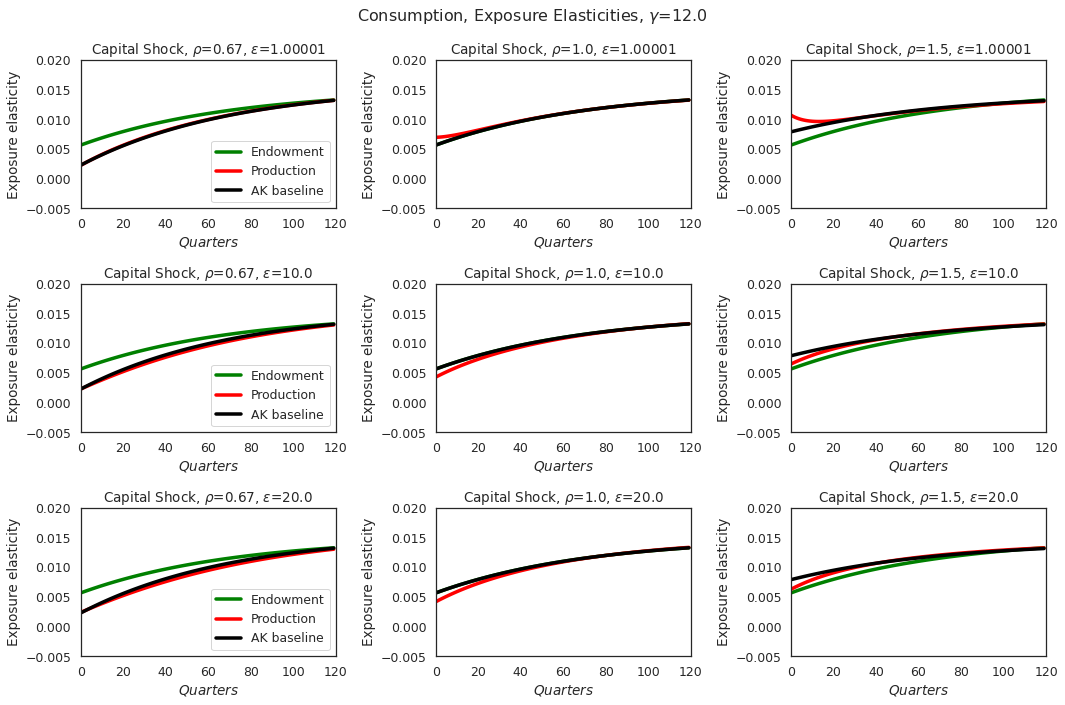

In [16]:
def plot_data(ax, data_adj_endowment, data_adj_production, data_baseline_AK, gamma, rho, epsilon):

    sns.lineplot(data=data_adj_endowment[rho, epsilon]['expo_elas_shock_0_C'][1].flatten(), ax=ax, color = 'green', label = r'Endowment')
    sns.lineplot(data=data_adj_production[rho, epsilon]['expo_elas_shock_0_C'][1].flatten(), ax=ax, color = 'red', label = r'Production')
    sns.lineplot(data=data_baseline_AK[rho]['expo_elas_shock_0_C'][1].flatten(), ax=ax, color = 'black', label = 'AK baseline')

    ax.set_ylim([-0.005, 0.02])
    ax.set_xlim([0.0, 120.0])
    ax.set_ylabel(r'Exposure elasticity')
    ax.set_xlabel(r'$Quarters$')
    if rho == 1.00001:
        ax.set_title(r'Capital Shock, '+'$\\rho$'+'='+str(1.0) + ', '+ '$\\epsilon$'+'='+str(epsilon))
    else:
        ax.set_title(r'Capital Shock, '+'$\\rho$'+'='+str(rho) + ', '+ '$\\epsilon$'+'='+str(epsilon))
    if (j) != 0:
        ax.get_legend().remove()
    plt.suptitle('Consumption, Exposure Elasticities, '+ '$\\gamma$'+'='+str(gamma), fontsize=16)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

gammas = [12.0,12.0,12.0]
rhos = [0.67, 1.00001, 1.5]
epsilons = [1.00001,10.0, 20.0]
for i, epsilon in enumerate(epsilons):
    for j, (gamma, rho) in enumerate(zip(gammas, rhos)):
        plot_data(axes[i, j], elast_adj_endow, elast_adj, elast_baseline_AK, gamma, rho, epsilon)

fig.tight_layout()
plt.show()

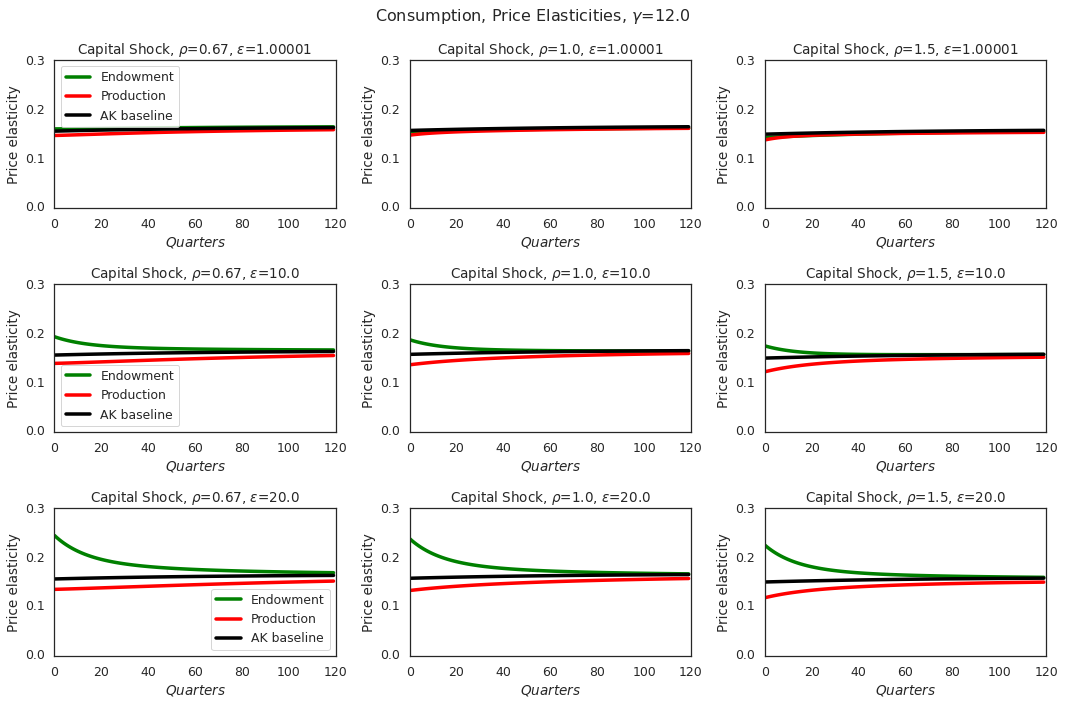

In [17]:
def plot_data(ax, data_adj_endowment, data_adj_production, data_baseline_AK, gamma, rho, epsilon):

    sns.lineplot(data=data_adj_endowment[rho, epsilon]['price_elas_shock_0_C'][1].flatten(), ax=ax, color = 'green', label = r'Endowment')
    sns.lineplot(data=data_adj_production[rho, epsilon]['price_elas_shock_0_C'][1].flatten(), ax=ax, color = 'red', label = r'Production')
    sns.lineplot(data=data_baseline_AK[rho]['price_elas_shock_0_C'][1].flatten(), ax=ax, color = 'black', label = 'AK baseline')

    ax.set_ylim([-0.005, 0.3])
    ax.set_xlim([0.0, 120.0])
    ax.set_ylabel(r'Price elasticity')
    ax.set_xlabel(r'$Quarters$')
    if rho == 1.00001:
        ax.set_title(r'Capital Shock, '+'$\\rho$'+'='+str(1.0) + ', '+ '$\\epsilon$'+'='+str(epsilon))
    else:
        ax.set_title(r'Capital Shock, '+'$\\rho$'+'='+str(rho) + ', '+ '$\\epsilon$'+'='+str(epsilon))
    if (j) != 0:
        ax.get_legend().remove()
    plt.suptitle('Consumption, Price Elasticities, '+ '$\\gamma$'+'='+str(gamma), fontsize=16)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

gammas = [12.0,12.0,12.0]
rhos = [0.67, 1.00001, 1.5]
epsilons = [1.00001,10.0, 20.0]
for i, epsilon in enumerate(epsilons):
    for j, (gamma, rho) in enumerate(zip(gammas, rhos)):
        plot_data(axes[i, j], elast_adj_endow, elast_adj, elast_baseline_AK, gamma, rho, epsilon)

fig.tight_layout()
plt.show()